# Восстановление золота из руды

Задача состоит в изготовлении прототипа модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Мы будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Мы проделаем следующие шаги:

1. Подготовим данные;
2. Проведем исследовательский анализ данных;
3. Построим и обучим модель.



## Подготовка данных

В нашем распоряжении файлы с технологическими признаками в формате [этап].[тип_параметра].[название_параметра]. 

Возможные значения для блока [этап]:
-   rougher — флотация
-   primary_cleaner — первичная очистка
-   secondary_cleaner — вторичная очистка
-   final — финальные характеристики

Возможные значения для блока [тип_параметра]:
 -   input — параметры сырья
 -   output — параметры продукта
 -   state — параметры, характеризующие текущее состояние этапа
 -   calculation — расчётные характеристики


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats as st
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
warnings.filterwarnings('ignore')


In [11]:
try:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
    train = pd.read_csv('C:\\YP\\gold_recovery_train_new.csv')
try:
    test = pd.read_csv('//datasets/gold_recovery_test_new.csv')
except:
    test = pd.read_csv('C:\\YP\\gold_recovery_test_new.csv')
try:
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    full = pd.read_csv('C:\\YP\\gold_recovery_full_new.csv')
train.info()
test.info()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### Эффективность обогащения
Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на тестовой выборке для признака `rougher.output.recovery` по формуле 
$$
{Recovery} = \frac {C*(F-T)}{F*(C-T)}*100 %,
$$
где C — доля золота в концентрате после флотации;     F — доля золота в сырье до флотации;     T — доля золота в отвальных хвостах после флотации.
В датасете С = `rougher.output.concentrate_au` (14149 значений), F = `rougher.input.feed_au`(14149 значений), T = `rougher.output.tail_au `(14149 значений). 

In [12]:
train['rougher.output.recovery.predictions'] =(( train['rougher.output.concentrate_au']*(train['rougher.input.feed_au'] 
                                                                                         - train['rougher.output.tail_au']))/
                                               (train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']
                                                                                  - train['rougher.output.tail_au']))*100)
display(train[['rougher.output.recovery', 'rougher.output.recovery.predictions']].head())
print('MAE расчётами эффективности обогащения и значением признака', mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery.predictions']))

,rougher.output.recovery,rougher.output.recovery.predictions
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


MAE расчётами эффективности обогащения и значением признака 9.73512347450521e-15


Мы видим, что среднее абсолютное отклонение рассчитанных значений от значений признака очень мало, значит, эффективность обогачещния расчитана верно.

### Работа с пропусками
Поскольку процесс развивается непрерывно во времени и близкие по времени значения похожи, то для обучения модели мы будем заполнять пропущенные значения похожими.

In [13]:
train = train.fillna(method = 'ffill')
test = test.fillna(method = 'ffill')
full = full.fillna(method = 'ffill')

## Анализ данных
### Концентрация различных металлов после флотации, после первичной очистки и в финальном концентрате (после втого этапа очистки)

Ниже представлены распределения концентрации золота, серебра и свинца на различных этапах очистки, а также графики boxplot для этих распределений. Мы видим, что концентрация золота растёт, концентрация серебра падает, а концентрация свинца падает с последующей стабилизацией. Главный вывод, который  мы можем сделать, что данные действительно отражают различные этапы очистки, обратного процесса не происходит.

In [14]:
data_au = pd.concat([full['rougher.output.concentrate_au'].describe(), full['primary_cleaner.output.concentrate_au'].describe(),
                            full['final.output.concentrate_au'].describe()], axis=1)
display(data_au)



,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19439.000000,19439.000000,19439.000000
mean,19.772000,32.119400,44.076513
std,3.753600,5.627611,5.129784
min,0.000000,0.000000,0.000000
25%,18.802523,30.463140,43.402215
50%,20.280214,32.841295,45.011244
75%,21.717843,35.048006,46.275313
max,28.824507,45.933934,52.756638


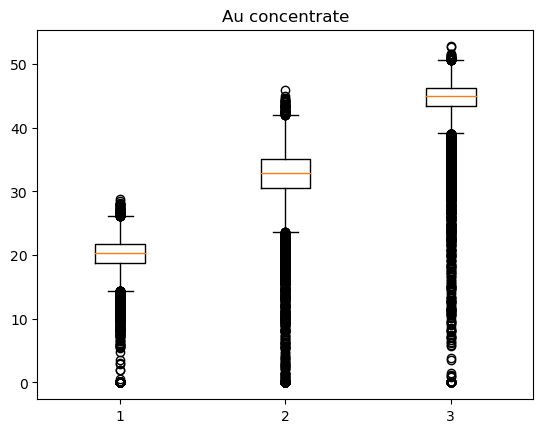

In [15]:
plt.boxplot ([full['rougher.output.concentrate_au'], full['primary_cleaner.output.concentrate_au'], 
              full['final.output.concentrate_au']])
plt.title('Au concentrate')
plt.show()

In [16]:
data_ag = pd.concat([full['rougher.output.concentrate_ag'].describe(), full['primary_cleaner.output.concentrate_ag'].describe(),
                            full['final.output.concentrate_ag'].describe()], axis=1)
display(data_ag)

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19439.000000,19439.000000,19439.000000
mean,11.994759,8.442408,5.168387
std,2.733862,2.054465,1.372362
min,0.000000,0.000000,0.000000
25%,10.628337,7.263288,4.251000
50%,12.098115,8.507298,5.066039
75%,13.736996,9.809001,5.895401
max,24.480271,16.081632,16.001945


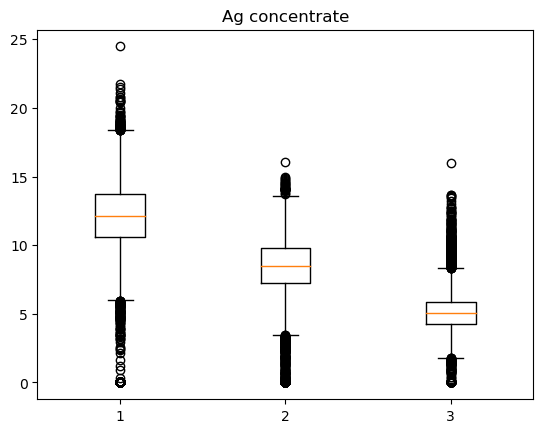

In [17]:
plt.boxplot ([full['rougher.output.concentrate_ag'], full['primary_cleaner.output.concentrate_ag'], 
              full['final.output.concentrate_ag']])
plt.title('Ag concentrate')
plt.show()

In [18]:
data_pb = pd.concat([full['rougher.output.concentrate_pb'].describe(), full['primary_cleaner.output.concentrate_pb'].describe(),
                            full['final.output.concentrate_pb'].describe()], axis=1)
display(data_pb)

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19439.000000,19439.000000,19439.000000
mean,7.606272,9.810317,9.978821
std,1.796757,2.572253,1.669228
min,0.000000,0.000000,0.000000
25%,6.725987,8.676500,9.137225
50%,7.742580,10.142270,10.102264
75%,8.565199,11.416298,11.035644
max,13.617072,17.081278,17.031899


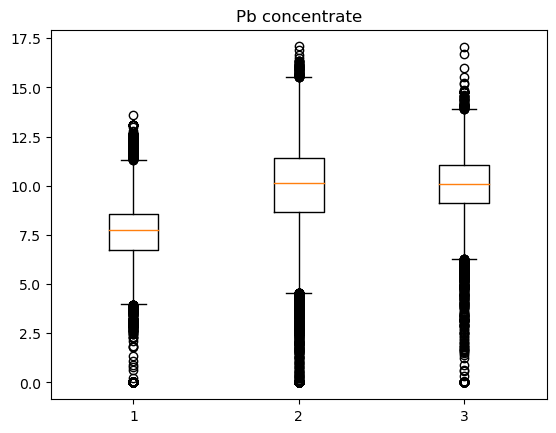

In [19]:
plt.boxplot ([full['rougher.output.concentrate_pb'], full['primary_cleaner.output.concentrate_pb'], 
              full['final.output.concentrate_pb']])
plt.title('Pb concentrate')
plt.show()

### Распределения размеров гранул сырья на обучающей и тестовой выборках.

Мы видим, что распределия размеров гранул сырья на обущающей и тестовой выборках отличаются, но не очень сильно (средние равны 60.24 и 55.95, соответственно, дисперсии близки). 

,rougher.input.feed_size,rougher.input.feed_size
count,14149.000000,5290.000000
mean,60.239856,55.952754
std,23.005310,19.080334
min,9.659576,0.046369
25%,48.966751,43.906504
50%,55.269784,50.846843
75%,66.007526,62.451165
max,484.967466,392.494040


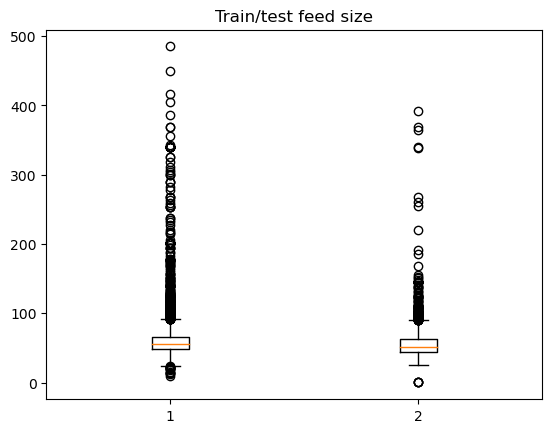

In [20]:
feed_size = pd.concat([train['rougher.input.feed_size'].describe(), test['rougher.input.feed_size'].describe()], axis = 1)
display(feed_size)
plt.boxplot ([train['rougher.input.feed_size'],test['rougher.input.feed_size']] )
plt.title('Train/test feed size')
plt.show()



### Суммарная концентрация веществ
Мы видим, что суммарная концентрация веществ на тестовой выборке принимает неожиданные значения: на графике типа boxplot мы видим аномалии, когда суммарная концентрация близка к нулю. Это может свидетельствовать о неверной записи данных, обработаем эти аномалии, убрав строки, в которых суммарная концентрация близка к нулю.




In [21]:
train['final.output.concentrate.sum']= (train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] +
                                        train['final.output.concentrate_au']+train['final.output.concentrate_sol'])
train['rougher.output.concentrate.sum']= (train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] +
                                        train['rougher.output.concentrate_au']+train['rougher.output.concentrate_sol'])
train['rougher.input.feed.sum']= (train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] +
                                        train['rougher.input.feed_au']+train['rougher.input.feed_sol'])



,rougher.input.feed.sum,rougher.output.concentrate.sum,final.output.concentrate.sum
count,14149.000000,14149.000000,14149.000000
mean,56.242170,67.173145,68.387872
std,7.029808,12.713129,7.023723
min,0.040000,0.000000,0.000000
25%,52.573579,64.914390,67.559819
50%,56.627635,69.175663,69.141502
75%,60.763234,73.429261,70.974661
max,74.458253,88.140119,80.210644


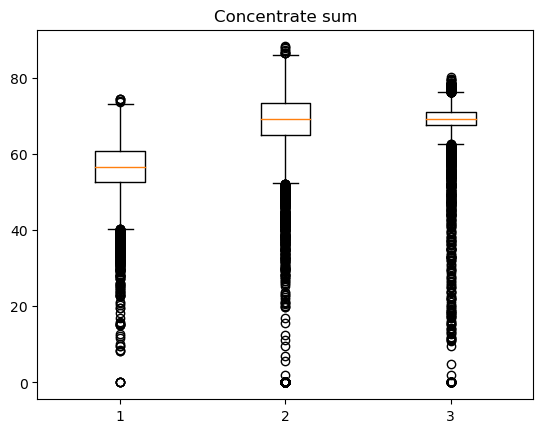

In [22]:
concentration_sum = pd.concat([train['rougher.input.feed.sum'].describe(), train['rougher.output.concentrate.sum'].describe(), train['final.output.concentrate.sum'].describe()], axis = 1)
display(concentration_sum)

plt.boxplot ([train['rougher.input.feed.sum'], train['rougher.output.concentrate.sum'], 
              train['final.output.concentrate.sum']]) 
plt.title('Concentrate sum')
plt.show()

In [23]:
train = (train[(train['final.output.concentrate.sum'] >5) &
               (train['rougher.input.feed.sum'] >5) & (train['rougher.output.concentrate.sum'] >5) ])

concentration_sum = pd.concat([train['rougher.output.concentrate.sum'].describe(), train['rougher.input.feed.sum'].describe(), train['final.output.concentrate.sum'].describe()], axis = 1)
display(concentration_sum)

#plt.boxplot ([train['final.output.concentrate.sum'], train['primary_cleaner.output.concentrate.sum'], train['rougher.output.concentrate.sum']] )
#plt.title('Concentrate sum')
#plt.show()

,rougher.output.concentrate.sum,rougher.input.feed.sum,final.output.concentrate.sum
count,13787.000000,13787.000000,13787.000000
mean,68.643069,56.247206,68.679486
std,7.974175,6.886062,5.349792
min,5.577864,8.217984,9.625832
25%,65.253549,52.543446,67.560878
50%,69.313300,56.626743,69.137438
75%,73.508433,60.761560,70.954557
max,88.140119,74.458253,80.210644


## Модель
Мы будем прогнозировать 2 величины:
 - эффективность обогащения чернового концентрата `rougher.output.recovery`
 - эффективность обогащения финального концентрата `final.output.recovery`
 
 В качестве метрики будем рассматривать симметричное среднее абсолютное процентное отклонение - sMAPE, рассчитываемое по формуле (в процентах)
 $$
 sMAPE = \frac 1 N \sum_{i=1}^N \frac {|y_i - \hat{y}_i|} {(|y_i| + |\hat{y}_i|)/2} *100
 $$

Итоговое качество мы будем оценивать с помощью формулы
$$
sMAPE = 0.25*sMAPE(rougher) + 0.75*sMAPE(final)
$$

In [24]:
def smape(predictions, target):
    eps=1e-6
    pt = pd.concat([pd.Series(predictions), pd.Series(target)], axis=1)
    pt['smape'] = abs(pt[0] - pt[1])/((abs(pt[0]) +abs(pt[1])+eps)/2)*100
    return pt['smape'].sum()/pt.shape[0]

smape_score = make_scorer(smape, greater_is_better=False)

Мы будем обучать 3 модели: 
- модель линейной регрессии
- модель случайного леса 
- модель дерева решений.

### Обучающая и тестовая выборки
Мы видим, что в тестовом датафрейме отсутствуют некоторые столбцы, присутствующие в тренировочном, это означает, что для обучения моделей мы можем использовать только те данные, которые присутствуют в тесте.
Разобьём датафрейм на тренировочную и тестовую выборки, оставив в тренировочной выборке только столбцы, присутствующие в тестовой (кроме того, учтём, что этапы для предсказания эффективности обогащения чернового концентрата - только связанные со флотацией (rougher), а для предсказания эффективности обогащения финального концентрата можем использовать все имеющиеся данные).

In [25]:
stages = list(test.columns)

stages_rougher = [item for item in stages if (item.find('rougher.input') != -1)|(item.find('rougher.state') != -1)]
#print(stages_rougher)
stages_final = stages[1:53] 

features_train_rougher = train[stages_rougher]
target_train_rougher = train['rougher.output.recovery']

dates = test['date'].values
target_test_rougher = full[full['date'].isin(dates)]['rougher.output.recovery'].values
features_test_rougher = test[stages_rougher]


features_train_final = train[stages_final]
target_train_final = train['final.output.recovery']

target_test_final = full[full['date'].isin(dates)]['final.output.recovery'].values
features_test_final = test[stages_final]

#проверка правильности отбора признаков
print(features_train_rougher.shape)
print(target_train_rougher.shape)


(13787, 22)
(13787,)


### Линейная регрессия

In [26]:
lr_rougher = LinearRegression()
grid = {}
gcv_rougher = GridSearchCV(lr_rougher, param_grid=grid, scoring=smape_score, n_jobs=-1)
gcv_rougher.fit(features_train_rougher, target_train_rougher)
best_model = gcv_rougher.best_estimator_
predictions_test_rougher = best_model.predict(features_test_rougher)
smape_lr_rougher = smape(predictions_test_rougher, target_test_rougher)
print('sMAPE для линейной регрессии (rougher) на тестовой выборке =', smape_lr_rougher)

lr_final = LinearRegression()
grid = {}
gcv_final = GridSearchCV(lr_final, param_grid=grid, scoring=smape_score, n_jobs=-1)
gcv_final.fit(features_train_final, target_train_final)
best_model = gcv_final.best_estimator_
predictions_test_final = best_model.predict(features_test_final)
smape_lr_final = smape(predictions_test_final, target_test_final)
print('sMAPE для линейной регрессии (final) на тестовой выборке =', smape_lr_final)

print('sMAPE для линейной регрессии итоговый = ', 0.25*smape_lr_rougher + 0.75*smape_lr_final)

sMAPE для линейной регрессии (rougher) на тестовой выборке = 8.196484512080517
sMAPE для линейной регрессии (final) на тестовой выборке = 9.996829233943219
sMAPE для линейной регрессии итоговый =  9.546743053477543


### Случайный лес

In [27]:
rfc = RandomForestRegressor(random_state = 12345)
grid = {'n_estimators': (1, 10, 1), 'max_depth': (1,5)}

gcv_rougher = GridSearchCV(rfc, param_grid=grid, scoring=smape_score, n_jobs=-1)
gcv_rougher.fit(features_train_rougher, target_train_rougher)
best_score = gcv_rougher.best_score_
best_model = gcv_rougher.best_estimator_
best_params = gcv_rougher.best_params_
predictions_test_rougher = best_model.predict(features_test_rougher)

#print(best_params_rougher)

smape_rfc_rougher = smape(predictions_test_rougher, target_test_rougher)
print('sMAPE для случайного леса (rougher) =', smape_rfc_rougher)

sMAPE для случайного леса (rougher) = 10.076608068669737


In [28]:
rfc = RandomForestRegressor(random_state = 12345)
grid = {'n_estimators': (1, 10), 'max_depth': (1,5)}

gcv_final = GridSearchCV(rfc, param_grid=grid, scoring=smape_score, n_jobs=-1)
gcv_final.fit(features_train_final, target_train_final)
best_score = gcv_final.best_score_
best_model = gcv_final.best_estimator_
best_params = gcv_final.best_params_
predictions_test_final = best_model.predict(features_test_final)

#print(best_params)

smape_rfc_final = smape(predictions_test_final, target_test_final)
print('sMAPE для случайного леса (final) =', smape_rfc_final)

sMAPE для случайного леса (final) = 9.603328567069317


In [29]:
print('sMAPE для случайного леса итоговый = ', 0.25*smape_rfc_rougher + 0.75*smape_rfc_final)

sMAPE для случайного леса итоговый =  9.721648442469421


### Дерево решений

In [30]:
dtr = DecisionTreeRegressor(random_state = 12345)
grid = {'min_samples_split': (2, 5), 'max_depth': (1,5)}

dtr_rougher = GridSearchCV(dtr, param_grid=grid, scoring=smape_score, n_jobs=-1)
dtr_rougher.fit(features_train_rougher, target_train_rougher)
best_score = dtr_rougher.best_score_
best_model = dtr_rougher.best_estimator_
best_params = dtr_rougher.best_params_
predictions_test_rougher = best_model.predict(features_test_rougher)

#print(best_params)

smape_dtr_rougher = smape(predictions_test_rougher, target_test_rougher)
print('sMAPE для дерева решений (rougher) =', smape_dtr_rougher)

sMAPE для дерева решений (rougher) = 10.005624927351306


In [31]:
dtr = DecisionTreeRegressor(random_state = 12345)
grid = {'min_samples_split': (2, 5), 'max_depth': (1,5)}

dtr_final = GridSearchCV(dtr, param_grid=grid, scoring=smape_score, n_jobs=-1)
dtr_final.fit(features_train_final, target_train_final)
best_score = dtr_final.best_score_
best_model = dtr_final.best_estimator_
best_params = dtr_final.best_params_
predictions_test_final = best_model.predict(features_test_final)

print(best_params)

smape_dtr_final = smape(predictions_test_final, target_test_final)
print('sMAPE для дерева решений (final) =', smape_dtr_final)

{'max_depth': 1, 'min_samples_split': 2}
sMAPE для дерева решений (final) = 9.600987066256868


In [32]:
print('sMAPE для дерева решений итоговый = ', 0.25*smape_dtr_rougher + 0.75*smape_dtr_final)

sMAPE для дерева решений итоговый =  9.702146531530477


## Адекватность модели (сравнение с константной моделью)
Построим константную модель, предсказывая целевые значения средними по тренировочной выборке.

In [33]:
predictions_test_rougher = [target_train_rougher.mean()]*len(target_test_rougher)


In [34]:
smape_const_rougher = smape(predictions_test_rougher, target_test_rougher)
print('sMAPE для константной модели (rougher) =', smape_const_rougher)

sMAPE для константной модели (rougher) = 9.067226744718146


In [35]:
predictions_test_final = [target_train_final.mean()]*len(target_test_final)

In [36]:
smape_const_final = smape(predictions_test_final, target_test_final)
print('sMAPE для константной модели (final) =', smape_const_final)

sMAPE для константной модели (final) = 10.080000719016462


In [37]:
print('sMAPE для константной модели итоговый = ', 0.25*smape_const_rougher + 0.75*smape_const_final)

sMAPE для константной модели итоговый =  9.826807225441884


## Вывод
Лучший результат дала модель **регрессии с помощью линейной регрессии**. Итоговая ошибка составила менее 9.55. Дерево решений и регрессия с помощью случайного леса дали худший результат (итоговые ошибки составили 9.7 и 9.75, соответственно). Кроме того, мы дополнительно рассмотрели константную модель, предсказывая итоговую эффективность обогащения средними значениями, полученными по тренировочной выборке. Ошибка константной модели составила 9.83. Таким образом, построенные модели имеют лучшее качество по сравнению с константной, хотя и незначительно.